In [5]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, models, transforms
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


In [6]:
# Hyperparameters
learning_rate = 1e-6
batch_size = 50
NUM_EPOCHS = 1  
momentum = 0.9
loss_function = nn.CrossEntropyLoss()

# Architecture
NUM_CLASSES = 10

In [7]:
def train_model(data_loader, network, optimizer, criterion, num_epochs=NUM_EPOCHS):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    network.to(device)
    network.train()
    for epoch in range(num_epochs):
        running_loss = epoch_loss = 0.
        for i, data in enumerate(data_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = network(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()

            if i % BATCH_TO_PRINT == (BATCH_TO_PRINT - 1):
                print('[Epoch %d, Batch %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / BATCH_TO_PRINT))
                running_loss = 0.0

        writer.add_scalar(f'Loss/train:', epoch_loss / len(data_loader), epoch)
        print(f"[{epoch + 1}] loss: {epoch_loss / len(data_loader):.3f}")

    writer.flush()
    return network


def test_model(data_loader, network):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    network.to(device)
    network.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = network(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(F'Test accuracy: {(100 * correct / total):.2f}%')

In [8]:
MNIST_IMAGE_SIZE = 28

num_input_channels = 1
num_output_classes = 10

num_conv1_channels = 32
conv_kernel_size = 3
conv_stride = 1
conv_padding = 1
pool_kernel_size = 2
num_conv2_channels = 64

fc1_output_size = 128
fc2_output_size = 64
fc3_output_size = 32

dropout_rate = 0.25

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=num_input_channels,
            out_channels=num_conv1_channels,
            kernel_size=conv_kernel_size,
            stride=conv_stride,
            padding=conv_padding,
        )
        self.conv2 = nn.Conv2d(
            in_channels=num_conv1_channels,
            out_channels=num_conv2_channels,
            kernel_size=conv_kernel_size,
            stride=conv_stride,
            padding=conv_padding,
        )
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=pool_kernel_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(
            num_conv2_channels * MNIST_IMAGE_SIZE**2 // pool_kernel_size**4,
            fc1_output_size,
        )
        self.fc2 = nn.Linear(fc1_output_size, fc2_output_size)
        self.fc3 = nn.Linear(fc2_output_size, fc3_output_size)
        self.fc4 = nn.Linear(fc3_output_size, num_output_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        return x


In [9]:
transform = transforms.Compose(
    [transforms.ToTensor()]
)
mnist_training_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
mnist_test_data = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=mnist_training_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=mnist_test_data, batch_size=64, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [10]:
learning_rate = 1e-6

my_model = CNN()
optimizer = optim.Adam(my_model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
BATCH_TO_PRINT = 100
writer = SummaryWriter()

In [11]:
trained_network = train_model(train_loader, my_model, optimizer, loss_function, num_epochs=1)

[Epoch 1, Batch   100] loss: 2.311
[Epoch 1, Batch   200] loss: 2.307
[Epoch 1, Batch   300] loss: 2.309
[Epoch 1, Batch   400] loss: 2.306
[Epoch 1, Batch   500] loss: 2.305
[Epoch 1, Batch   600] loss: 2.306
[Epoch 1, Batch   700] loss: 2.306
[Epoch 1, Batch   800] loss: 2.305
[Epoch 1, Batch   900] loss: 2.305
[1] loss: 2.307


In [12]:
torch.save(trained_network.state_dict(), 'my-cnn-mnist_exercise3.pt')

In [13]:
test_model(test_loader, trained_network)

Test accuracy: 9.58%


Feature Extraction

In [25]:
# Load the trained model
model = CNN()
model.load_state_dict(torch.load('my-cnn-mnist_exercise3.pt'))

# Create a new model with only the convolutional layers
feature_extractor = nn.Sequential(*list(model.children())[:-4])

# Extract features from the dataset
features = []
true_labels = []
for images, labels in test_loader:
    with torch.no_grad():
        x = feature_extractor(images)
        features.append(x.flatten(start_dim=1))
        true_labels.append(labels)
features = torch.cat(features, dim=0)
true_labels = torch.cat(true_labels, dim=0)

C:\Users\manou\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\manou\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


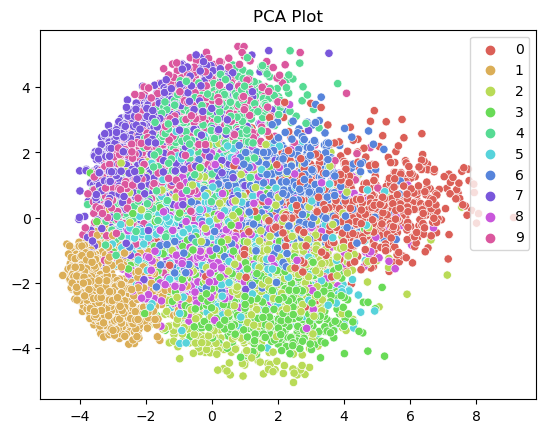

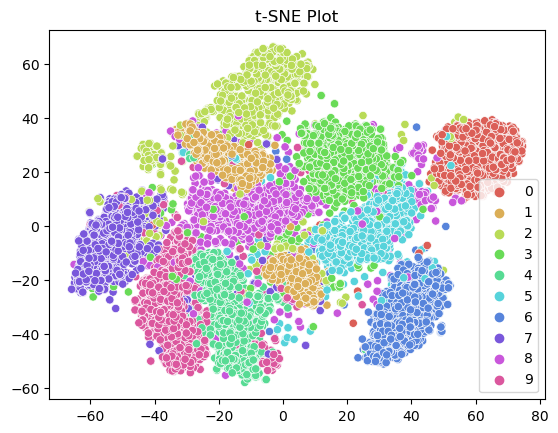

In [26]:

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features.numpy())

# Perform t-SNE
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(features.numpy())

# Plot the results
sns.scatterplot(x = pca_result[:,0], y = pca_result[:,1], hue = true_labels, palette = sns.hls_palette(10), legend = 'full')
plt.title("PCA Plot")
plt.show()
sns.scatterplot(x = tsne_result[:,0], y = tsne_result[:,1], hue = true_labels, palette = sns.hls_palette(10), legend = 'full')
plt.title("t-SNE Plot")
plt.show()


In [20]:
learning_rate = 1e-3
my_model = CNN()
optimizer = optim.Adam(my_model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
BATCH_TO_PRINT = 100
writer = SummaryWriter()
trained_network = train_model(train_loader, my_model, optimizer, loss_function, num_epochs=10)
torch.save(trained_network.state_dict(), 'my-cnn-mnist_2_exercise3.pt')
test_model(test_loader, trained_network)

[Epoch 1, Batch   100] loss: 1.738
[Epoch 1, Batch   200] loss: 0.730
[Epoch 1, Batch   300] loss: 0.442
[Epoch 1, Batch   400] loss: 0.340
[Epoch 1, Batch   500] loss: 0.268
[Epoch 1, Batch   600] loss: 0.221
[Epoch 1, Batch   700] loss: 0.218
[Epoch 1, Batch   800] loss: 0.192
[Epoch 1, Batch   900] loss: 0.171
[1] loss: 0.468
[Epoch 2, Batch   100] loss: 0.157
[Epoch 2, Batch   200] loss: 0.157
[Epoch 2, Batch   300] loss: 0.164
[Epoch 2, Batch   400] loss: 0.142
[Epoch 2, Batch   500] loss: 0.145
[Epoch 2, Batch   600] loss: 0.141
[Epoch 2, Batch   700] loss: 0.117
[Epoch 2, Batch   800] loss: 0.109
[Epoch 2, Batch   900] loss: 0.108
[2] loss: 0.137
[Epoch 3, Batch   100] loss: 0.112
[Epoch 3, Batch   200] loss: 0.107
[Epoch 3, Batch   300] loss: 0.098
[Epoch 3, Batch   400] loss: 0.100
[Epoch 3, Batch   500] loss: 0.104
[Epoch 3, Batch   600] loss: 0.096
[Epoch 3, Batch   700] loss: 0.082
[Epoch 3, Batch   800] loss: 0.099
[Epoch 3, Batch   900] loss: 0.098
[3] loss: 0.099
[Epoch 

C:\Users\manou\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\manou\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


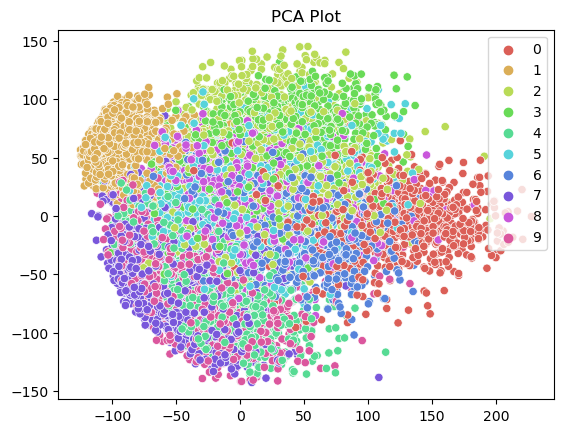

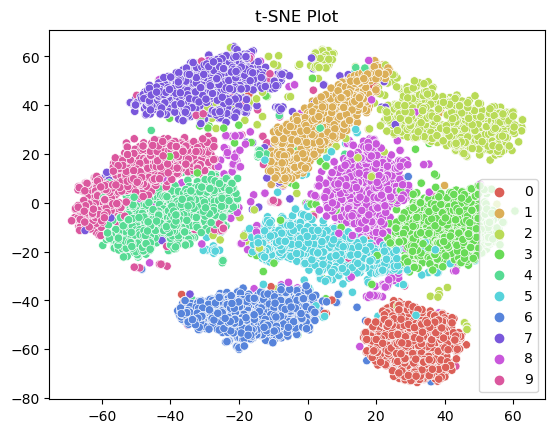

In [27]:
# Load the trained model
model = CNN()
model.load_state_dict(torch.load('my-cnn-mnist_2_exercise3.pt'))

# Create a new model with only the convolutional layers
feature_extractor = nn.Sequential(*list(model.children())[:-4])

# Extract features from the dataset
features = []
true_labels = []
for images, labels in test_loader:
    with torch.no_grad():
        x = feature_extractor(images)
        features.append(x.flatten(start_dim=1))
        true_labels.append(labels)
features = torch.cat(features, dim=0)
true_labels = torch.cat(true_labels, dim=0)


# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features.numpy())

# Perform t-SNE
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(features.numpy())

# Plot the results

sns.scatterplot(x = pca_result[:,0], y = pca_result[:,1], hue = true_labels, palette = sns.hls_palette(10), legend = 'full')
plt.title("PCA Plot")
plt.show()
sns.scatterplot(x = tsne_result[:,0], y = tsne_result[:,1], hue = true_labels, palette = sns.hls_palette(10), legend = 'full');
plt.title("t-SNE Plot")
plt.show()


The four visualization images show the visualized features of the first model using PCA and t-SNE, 
and the visualized features of the second model using PCA and t-SNE.
The main difference between PCA and t-SNE is that PCA is a linear technique while t-SNE is a non-linear technique. This means that t-SNE is better suited for visualizing complex, non-linear relationships between high-dimensional data, while PCA is better suited for visualizing linear relationships.
The first model has fewer learned features compared to the second model due to the smaller learning rate and shorter training time. As a result, the visualized features of the first model are less distinct and separated than those of the second model.
When using t-SNE for the two cases, the visualization of the first model's features may show the data points clustered together, indicating that the model has not yet learned to separate the data points into distinct groups. 
The visualization of the second model's features is shows more distinct clusters, indicating that the model has learned to separate the data points based on their features.